In [1]:
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from data_preprocessing import get_data

### Load Data

In [45]:
# X_train, y_train, X_test, y_test, y_scaler, train_loader, test_loader = get_data(
#             timestep = 10,
#             batch_size = 64,
#             y_name = 'Closing price',
#             train_size = 6627,
#             path = "Data/SSE000001.csv")
# y_test = y_scaler.inverse_transform(y_test)
# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [10]:
X_train, y_train, X_test, y_test, y_scaler, train_loader, test_loader = get_data(
            timestep = 10,
            batch_size = 64,
            y_name = 'Closing price',
            train_size = 0.9,
            path = "Data/SP500.csv")
y_test = y_scaler.inverse_transform(y_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([7698, 10, 8]) torch.Size([7698, 1]) torch.Size([847, 10, 8]) (847, 1)


In [11]:
X_train[0]

tensor([[-1.3262, -1.3299, -1.3236, -1.3278, -1.1383, -0.9716, -0.0762, -0.2560],
        [-1.3275, -1.3324, -1.3307, -1.3321, -1.1468, -0.9732, -0.2017, -0.7808],
        [-1.3318, -1.3368, -1.3329, -1.3370, -1.1570, -0.9751, -0.2238, -0.8803],
        [-1.3367, -1.3388, -1.3340, -1.3348, -1.1672, -0.9769,  0.0701,  0.3623],
        [-1.3344, -1.3389, -1.3354, -1.3407, -1.1588, -0.9754, -0.2644, -1.0571],
        [-1.3404, -1.3453, -1.3429, -1.3439, -1.1473, -0.9737, -0.1564, -0.6061],
        [-1.3436, -1.3445, -1.3386, -1.3422, -1.1593, -0.9757,  0.0487,  0.2750],
        [-1.3419, -1.3468, -1.3497, -1.3543, -1.1430, -0.9731, -0.5217, -2.1794],
        [-1.3540, -1.3588, -1.3538, -1.3585, -1.1669, -0.9773, -0.1924, -0.7814],
        [-1.3581, -1.3577, -1.3584, -1.3532, -1.1417, -0.9733,  0.1956,  0.9381]])

### GPU

In [12]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(device)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(device)
else:
    print ("GPU device not found.")

device = None

GPU device not found.


In [13]:
class LSTM(nn.Module):
    def __init__(self, input_size = 8, lstm_num_layers = 1, lstm_hidden_size = 64,  fc1_output_size = 16):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.lstm_num_layers = lstm_num_layers
        self.lstm_hidden_size = lstm_hidden_size
        # self.lstm_dropout = lstm_dropout
        self.fc1_output_size = fc1_output_size

        self.lstm = nn.LSTM(input_size = self.input_size, 
                             hidden_size = self.lstm_hidden_size,
                             num_layers = self.lstm_num_layers,
                             batch_first = True)

        # self.dropout = nn.Dropout(p = self.lstm_dropout)
        self.fc1 = nn.Linear(self.lstm_hidden_size, self.fc1_output_size)
        self.fc2 = nn.Linear(self.fc1_output_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.lstm_num_layers, x.size(0), self.lstm_hidden_size).to(device)
        c0 = torch.zeros(self.lstm_num_layers, x.size(0), self.lstm_hidden_size).to(device)

        # x = F.relu(x)

        h_lstm, _ = self.lstm(x, (h0, c0))
        # h_dropout = self.dropout(h_lstm)

        h_fc1 = self.fc1(h_lstm)
        h_fc1 = F.relu(h_fc1)

        h_fc2 = self.fc2(h_fc1)
        output = h_fc2[:, -1, :]

        return output

### Model

In [14]:
input_size = 8
lstm_num_layers = 1
lstm_hidden_size = 64
lstm_dropout = 0.2
fc1_output_size = 8
learning_rate = 0.0001
num_epoch = 20

model = LSTM(input_size=input_size, 
               lstm_num_layers=lstm_num_layers, 
               lstm_hidden_size=lstm_hidden_size, 
               fc1_output_size=fc1_output_size).to(device)

optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.L1Loss() # Mean Absolute Error

### Train

In [15]:
model.train(True)

for epoch in range(num_epoch):
    for batch_index, batch in enumerate(train_loader):
        X, y_true = batch[0].to(device), batch[1].to(device)
        y_pred = model(X)
        loss = criterion(y_pred, y_true)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 10 == 0:
            print('Epoch {0}, Batch {1}, Loss: {2:.6f}'.format(epoch, batch_index, loss.item()))
            display.clear_output(wait=True)

model.train(False)

LSTM(
  (lstm): LSTM(8, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)

In [16]:
# path = "models/BILSTM_{0}Epoch_{1}Lr_{2}Layer_{3}Size.pt".format(num_epoch, learning_rate, lstm_num_layers, lstm_hidden_size)
# torch.save(model.state_dict(), path)

### Evaluate

In [17]:
with torch.no_grad():
    y_train_pred = model(X_train.to(device)).to('cpu')
    y_test_pred = model(X_test.to(device)).to('cpu')

y_test_pred = y_scaler.inverse_transform(y_test_pred)

train_mse = mean_squared_error(y_train_pred, y_train, squared=False)
test_mse = mean_squared_error(y_test_pred, y_test, squared=False)

train_mae = mean_absolute_error(y_train_pred, y_train)
test_mae = mean_absolute_error(y_test_pred, y_test)

train_r2 = r2_score(y_train_pred, y_train)
test_r2 = r2_score(y_test_pred, y_test)

print("Train RMSE: {0:.6f}; Test RMSE {1:.6f}\n".format(train_mse, test_mse))
print("Train  MAE: {0:.6f}; Test  MAE {1:.6f}\n".format(train_mae, test_mae))
print("Train  R^2: {0:.6f}; Test  R^2 {1:.6f}\n".format(train_r2, test_r2))

Train RMSE: 0.025027; Test RMSE 599.897397

Train  MAE: 0.014560; Test  MAE 534.961372

Train  R^2: 0.999376; Test  R^2 -44.130090



#### Plot

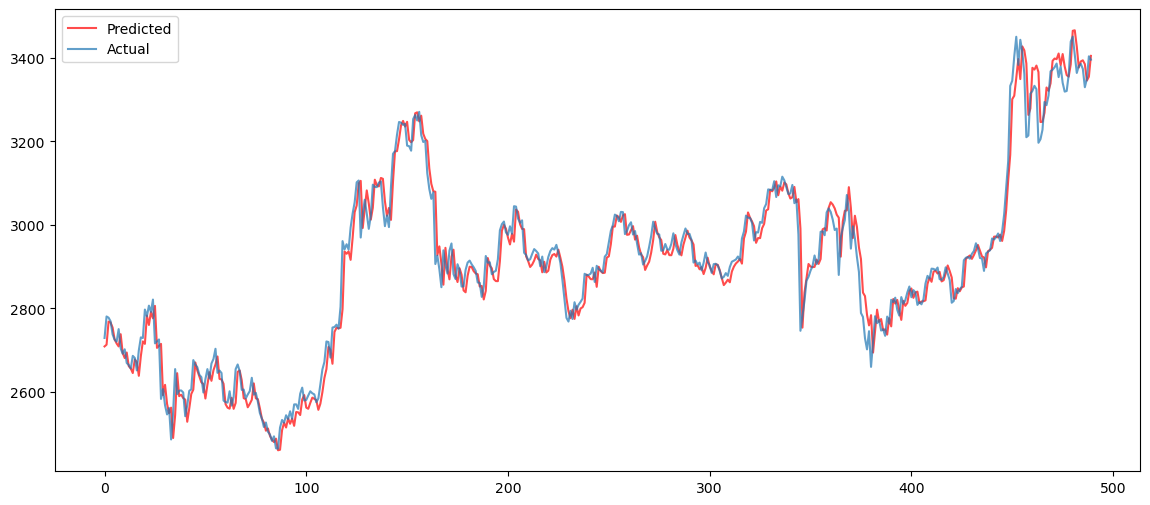

In [21]:
plt.figure(figsize=(14, 6))
plt.plot(y_test_pred, label='Predicted', alpha=0.7, color='red')
plt.plot(y_test, label='Actual', alpha=0.7)
plt.legend()
plt.show()